In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary

In [3]:
def get_transformations():
    train_transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=6),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=10, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    test_transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    return train_transform, test_transform

In [4]:
# Dataset
train_transform, test_transform = get_transformations()
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)
# Data Loader
train_data_loader  = torch.utils.data.DataLoader(train, batch_size=128,shuffle=True)
validation_data_loader  = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False)

100%|██████████| 170M/170M [00:15<00:00, 10.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
class SE_Block(torch.nn.Module):
    def __init__(self, channels, reduction=16):
        super(SE_Block, self).__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(channels, channels//reduction, bias = False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(channels//reduction, channels, bias = False),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        batch, channels, w, h = x.size()
        y = self.avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        return x * y.expand_as(x)

class ResNet_Block(torch.nn.Module): # This signifies one block with one skip connection
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None, use_se_block=False):
        super(ResNet_Block, self).__init__()
        self.convolution1 = torch.nn.Sequential(
                                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding=1), # Here the stride is not 1 because we might be coming from a bigger image size and we might need to downsample
                                torch.nn.BatchNorm2d(out_channels),
                                torch.nn.ReLU())
        self.convolution2 = torch.nn.Sequential(
                                torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1), # Here the stride is always 1 because this is the second conv layer is not downsampled
                                torch.nn.BatchNorm2d(out_channels))
        self.downsample = downsample # This will be not none if we are now changing. (Now we have a new block configuration)
        self.relu = torch.nn.ReLU()
        self.out_channels = out_channels
        self.use_se_block = use_se_block
        self.se_block = SE_Block(out_channels)


    def forward(self, x):
        res = x
        if self.downsample is not None:
            res = self.downsample(x)

        out = self.convolution1(x)
        out = self.convolution2(out)

        #SE Block
        if self.use_se_block:
          out = self.se_block(out)

        z = out + res
        z = self.relu(z)

        return z

class ResNet(torch.nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.block = block
        # Input = 3 channels, 32 * 32
        self.convolution1 = torch.nn.Sequential(
                                torch.nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
                                torch.nn.BatchNorm2d(64),
                                torch.nn.ReLU()) # 32*32
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.add_res_net_block(64, 64, layers[0], first_layer_stride = 1) # 32*32
        self.layer1 = self.add_res_net_block(64, 128, layers[1], first_layer_stride = 2)# 16*16
        self.layer2 = self.add_res_net_block(128, 256, layers[2], first_layer_stride = 2)#8*8
        self.avgpool = torch.nn.AvgPool2d(8, stride=1)
        self.fc = torch.nn.Linear(256, 10)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

    def add_res_net_block(self, in_channels, out_channels, layers, first_layer_stride):
        downsample = None
        num_layers, use_se_block = layers
        if first_layer_stride != 1 or in_channels != out_channels:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride=first_layer_stride),
                torch.nn.BatchNorm2d(out_channels)
            )
        block_layers = []
        block_layers.append(self.block(in_channels, out_channels, first_layer_stride, downsample))
        for i in range(num_layers-1):
            if i == num_layers - 2 and use_se_block:
                block_layers.append(self.block(out_channels, out_channels, 1, None, True))
            else:
                block_layers.append(self.block(out_channels, out_channels, 1, None, False))
        return torch.nn.Sequential(*block_layers)

    def forward(self, x):
        x = self.convolution1(x)
        # x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [16]:
def train_model(model, train_data_loader, validation_data_loader, label_smoothing = 0, lr = 0.1, weight_decay = 0.0005, momentum=0.9, nesterov=True, epochs=100):
    print(label_smoothing,lr, weight_decay , momentum, nesterov, epochs)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay, momentum=momentum, nesterov=nesterov)

    def lr_schedule_with_warmup(epoch):
        if epoch < 5:
            return (epoch+1)/5
        return 0.5 * (1 + np.cos(np.pi * (epoch-5)/(epochs-5)))

    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule_with_warmup)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 80], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)
    train_loss = []
    val_loss = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
      trainloss = 0.0
      valloss = 0.0
      val_correct = 0
      train_correct = 0
      val_total = 0
      train_total = 0
      model.train() # telling python that we are intereseted in updating any trainable parameters in the network

      for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # makes sure we have zeroes out gradients for trainable parameters from the previous iteration
        pred = model(images) # forward pass
        fit = loss(pred, labels)
        fit.backward() # backward
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step() # updates the weight
        trainloss += fit.item()
        _, predicted = torch.max(pred, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
      model.eval()
      for images, labels in validation_data_loader:
        with torch.no_grad():
          images = images.to(device)
          labels = labels.to(device)
          pred = model(images)
          fit = loss(pred, labels)
          valloss += fit.item()
          _, predicted = torch.max(pred, 1)
          val_correct += (predicted == labels).sum().item()
          val_total += labels.size(0)

      trainloss = trainloss/len(train_data_loader)
      valloss = valloss/len(validation_data_loader)
      val_loss.append(valloss)
      train_loss.append(trainloss)

      val_accuracy = 100 * val_correct/val_total
      val_accuracies.append(val_accuracy)
      train_accuracy = 100 * train_correct/train_total
      train_accuracies.append(train_accuracy)


      scheduler.step()

      print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {trainloss:.2f} | val loss: {valloss:.2f} | val Accuracy: {val_accuracy:.2f}%')

    return model, train_loss, val_loss, train_accuracies, val_accuracies

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(ResNet_Block, [(4, False),(4, False),(3, True)]).to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
     ResNet_Block-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [22]:
# lr = 0.001, weight_decay = 0.0001, momentum=0.8)
model, train_loss, val_loss, train_accuracies, val_accuracies = train_model(model, train_data_loader, validation_data_loader,label_smoothing = 0.1, lr = 0.1, weight_decay = 0.0005, momentum=0.9, nesterov=True, epochs=50)

0.1 0.1 0.0005 0.9 True 50
Epoch: 1/50 | Train Loss: 1.87 | val loss: 1.92 | val Accuracy: 44.08%
Epoch: 2/50 | Train Loss: 1.54 | val loss: 1.60 | val Accuracy: 54.56%
Epoch: 3/50 | Train Loss: 1.40 | val loss: 1.37 | val Accuracy: 63.13%
Epoch: 4/50 | Train Loss: 1.31 | val loss: 1.24 | val Accuracy: 69.24%
Epoch: 5/50 | Train Loss: 1.24 | val loss: 1.40 | val Accuracy: 63.45%
Epoch: 6/50 | Train Loss: 1.19 | val loss: 1.32 | val Accuracy: 66.35%
Epoch: 7/50 | Train Loss: 1.16 | val loss: 1.10 | val Accuracy: 75.10%
Epoch: 8/50 | Train Loss: 1.13 | val loss: 1.08 | val Accuracy: 75.81%
Epoch: 9/50 | Train Loss: 1.11 | val loss: 1.18 | val Accuracy: 72.10%
Epoch: 10/50 | Train Loss: 1.10 | val loss: 1.03 | val Accuracy: 77.86%
Epoch: 11/50 | Train Loss: 1.08 | val loss: 1.10 | val Accuracy: 75.19%
Epoch: 12/50 | Train Loss: 1.07 | val loss: 1.14 | val Accuracy: 73.95%
Epoch: 13/50 | Train Loss: 1.06 | val loss: 1.22 | val Accuracy: 70.87%
Epoch: 14/50 | Train Loss: 1.04 | val loss: 0.

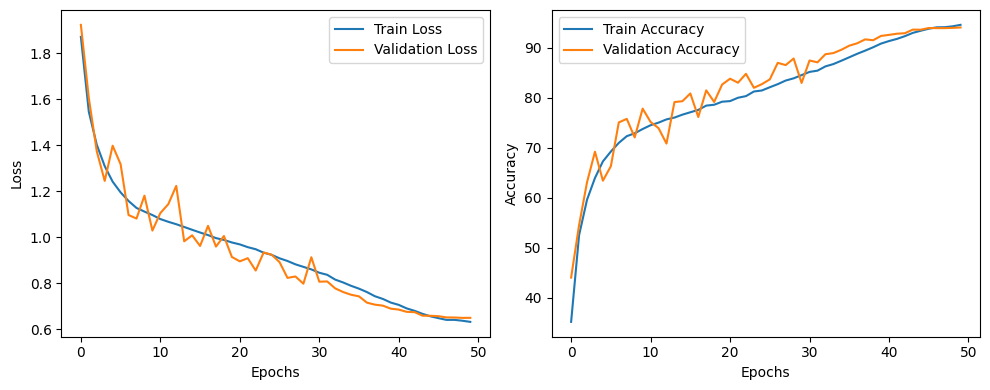

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(train_loss, label="Train Loss")
ax[0].plot(val_loss, label="Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(train_accuracies, label="Train Accuracy")
ax[1].plot(val_accuracies, label="Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()

In [ ]:
torch.save(model.state_dict(), './ResNet4_4_3.pth')

<ipython-input-129-d501dd5d0cd0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./ResNet4_4_3.pth')


In [27]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [29]:
pred_batch = unpickle('cifar_test_nolabel.pkl')
pred_images = pred_batch[b'data']
pred_dataset = [test_transform(img) for img in pred_images]
pred_loader =  torch.utils.data.DataLoader(pred_dataset, batch_size=128, shuffle = False)
model.eval()
predictions_made = []
with torch.no_grad():
  for images in pred_loader:
    images = images.to(device)
    pred = model(images)
    _, predicted = torch.max(pred, 1)
    predictions_made.extend(predicted.cpu().numpy())
benchmark = pd.DataFrame({'ID': [i for i in range(len(predictions_made))], 'Labels': predictions_made})
benchmark.to_csv('./benchmark.csv', index=False)